In this notebook, corresponding to sections 3 and 4 in our report, we implement and optimize Gaussian mixture models (GMM) as a density estimator (i.e. in an unsupervised context) and classifier (supervised) on the MNIST dataset. At the end, we also use both our supervised and unsupervised GMMs as generative models of the MNIST dataset, that is, generate samples from our GMMs which resemble the original data.

As in the previous notebook, more detailed explanations of procedures and results can be found in the write-up.

First, we use PCA (normalizing by sklearn's $\texttt{StandardScaler}$) to reduce the dimensionality of the dataset. Then, we train an unsupervised GMM tasked with estimating the probability density of the MNIST data. We fit the GMM to the dataset and plot the means of each class the GMM identified.

Number of principal components kept:  41
Means of classes of unsupervised model:


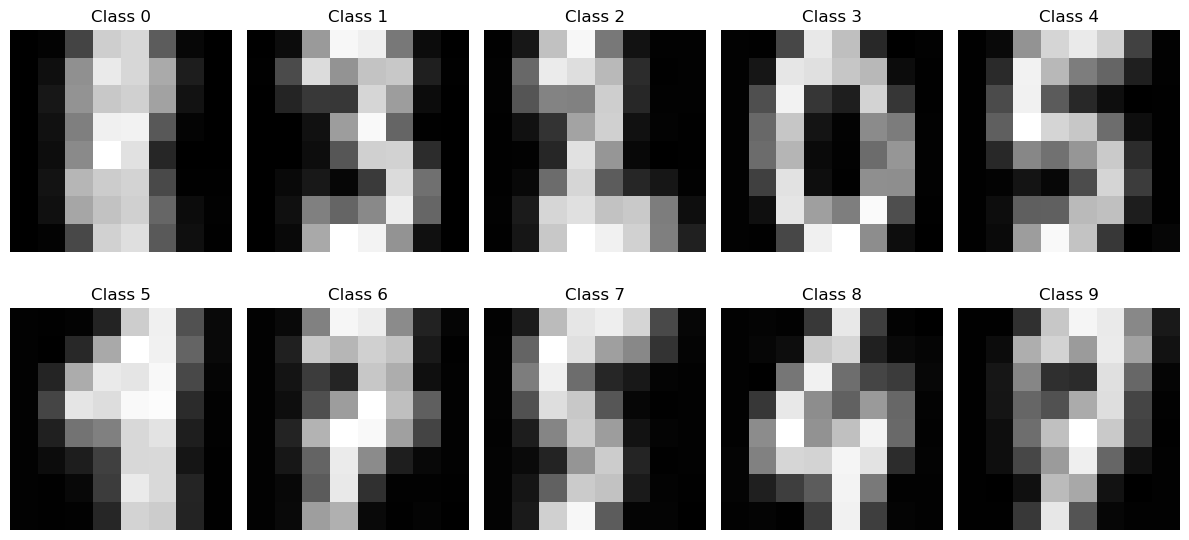

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

MNIST = load_digits()
X, y = MNIST.data, MNIST.target

# normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(np.float64))

# perform PCA to reduce dimensionality
delta = 0.99 #change this to keep enough principal components to account for (100 * delta)% of variance
pca = PCA(n_components=delta, random_state=42)  #
X_pca = pca.fit_transform(X)
print("Number of principal components kept: ", pca.n_components_)

n_components=15 # this is the number of components of our GMM.

# train a GMM without using class labels (unsupervised, density estimator)
gmmUnsupervised = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42).fit(X_pca, None)

# plot GMM means for each class
def plot_gmm_means(gmm, classes):
    plt.figure(figsize=(12, 6))
    for i in range(len(classes)):
        # find indices of samples belonging to the current class
        indices = np.where(y == classes[i])[0]
        
        # extract the PCA-transformed features of the current class
        X_class = pca.transform(X[indices])
        
        # plot GMM means
        means = gmm.means_[i]
        plt.subplot(2, 5, i + 1)
        mean_image = pca.inverse_transform(means).reshape(8, 8)  # reshape using inverse PCA transform
        plt.imshow(mean_image, cmap='gray')
        plt.title('Class {}'.format(classes[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print('Means of classes of unsupervised model:')
plot_gmm_means(gmmUnsupervised, np.unique(y))

Now, we use GMM as a classifier (supervised learning): we will train a GMM on each class of the dataset. Then, to classify using the GMMs, for each observation in the test set, we compute the log likelihood of the observation under each GMM. The "class" of the GMM corresponding to the highest log likelihood is considered the predicted class for that observation. 

Supposing we use the same number of Gaussian components for each of the 10 GMMs, we calculate that optimal number of components using BIC.

Optimal number of components according to BIC score: 12
BIC score: 16877.893435325233


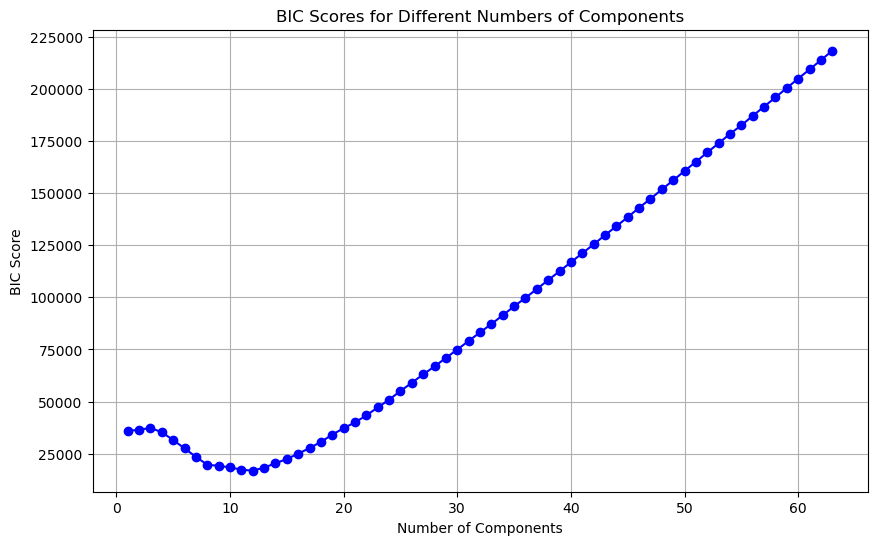

In [2]:
n_components_range = range(1, 64)
bic_scores = []

# get the unique class labels
classes = np.unique(y)

# initialize a list to store the GMMs for each class
gmms = []

# for all k in {numbers of components we wish to test}
for n_components in n_components_range:
    bic_scores_class = []
    # train a separate GMM for each class
    for c in classes:
        # extract the samples of the current class
        X_class = X_pca[y == c]
        
        # train a GMM on the samples of the current class
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42).fit(X_class)
        
        # add the trained GMM to the list
        gmms.append(gmm)
        
        # calculate its BIC; it gets n, k, and the likelihood function of the model from "gmm"
        bic_scores_class.append(gmm.bic(X_class))
    
    # calculate average BIC score for this number of components
    bic_scores.append(np.mean(bic_scores_class))

# store the results in a DataFrame
df = pd.DataFrame({
    'Number of Components': n_components_range,
    'BIC Score': bic_scores
})

# find/print the model with the lowest BIC score
optimal_model = df[df['BIC Score'] == df['BIC Score'].min()]
optimal_number_of_components = optimal_model['Number of Components'].values[0]

print("Optimal number of components according to BIC score:", optimal_model['Number of Components'].values[0])
print("BIC score:", optimal_model['BIC Score'].values[0])

# plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(df['Number of Components'], df['BIC Score'], marker='o', color='b', linestyle='-')
plt.title('BIC Scores for Different Numbers of Components')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()


Then, we train and test our supervised model, plotting the means of its predicted classes, and a confusion matrix of how well the model predicted the test data.

Means of classes of supervised model:


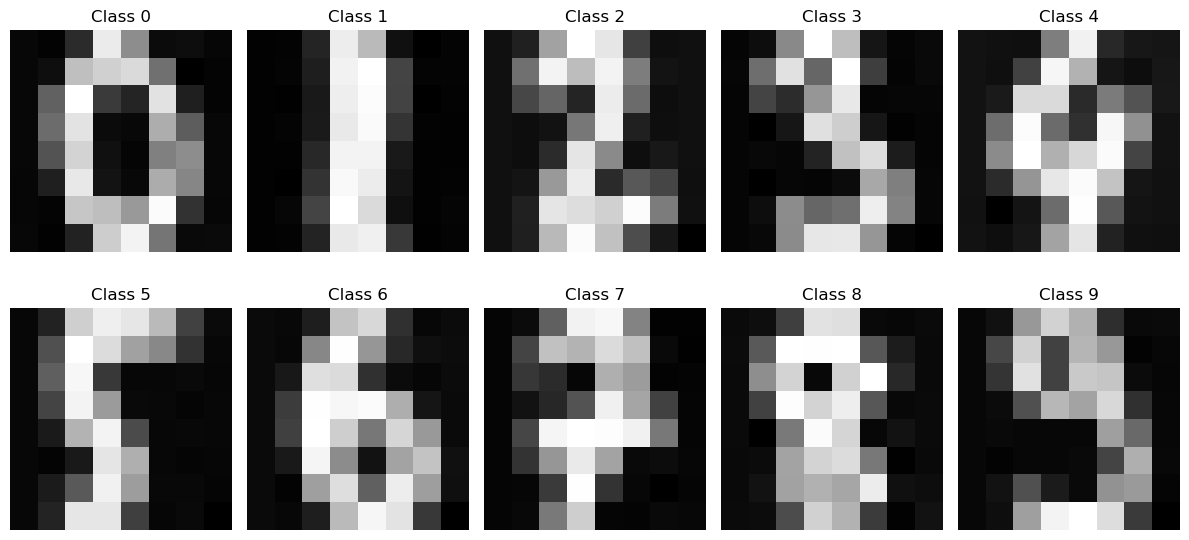

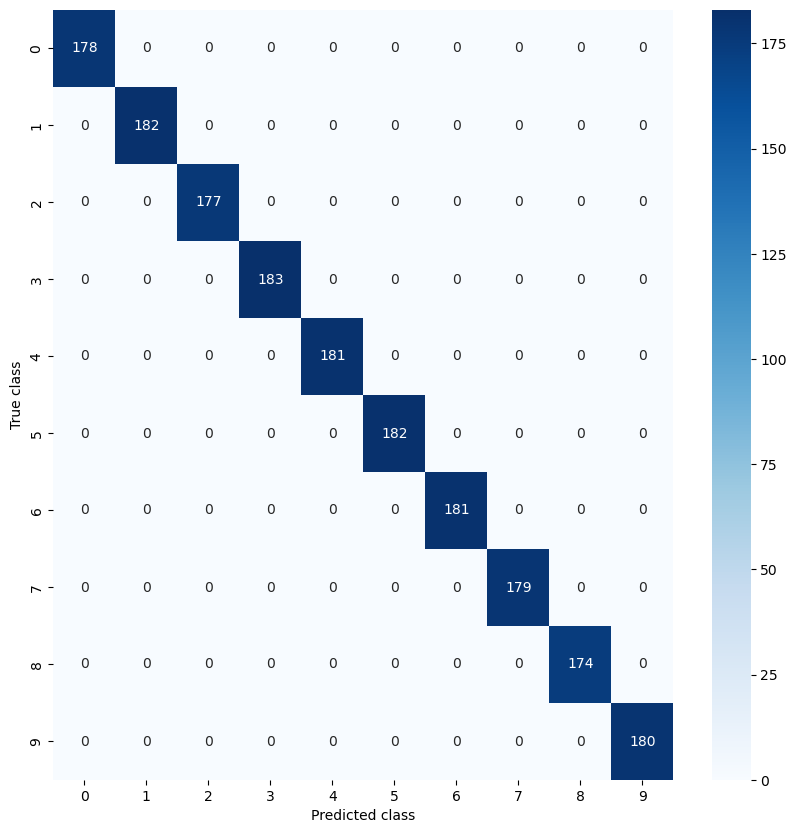

In [3]:
# get the unique class labels
classes = np.unique(y)

# initialize a list to store the GMMs for each class
gmms = []

# train a separate GMM for each class
for c in classes:
    # extract the samples of the current class
    X_class = X_pca[y == c]
    
    # train a GMM on the samples of the current class
    gmm = GaussianMixture(n_components=50, reg_covar=1e-2, covariance_type='full', random_state=42).fit(X_class)
    
    # Add the trained GMM to the list
    gmms.append(gmm)

# function to plot GMM means for each class
def plot_gmm_means(gmms, classes):
    plt.figure(figsize=(12, 6))
    for i in range(len(classes)):
        # Plot GMM means
        means = gmms[i].means_
        plt.subplot(2, 5, i + 1)
        mean_image = pca.inverse_transform(means[i]).reshape(8, 8)  # Reshape to 8x8
        plt.imshow(mean_image, cmap='gray')
        plt.title('Class {}'.format(classes[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print('Means of classes of supervised model:')
plot_gmm_means(gmms, classes)

# initialize an empty array to store the predictions
predictions = []

# for each sample, (we will predict the class label)
for sample in X_pca:
    
    # compute the log likelihood of the sample under each GMM
    log_likelihoods = [gmm.score_samples(sample.reshape(1, -1)) for gmm in gmms]
    
    # find the class with the highest log likelihood
    pred = np.argmax(log_likelihoods)
    
    # add the predicted class label to the list
    predictions.append(pred)

# compute the confusion matrix
cm = confusion_matrix(y, predictions)

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()



We can also try to use the confusion matrix on our unsupervised model, although the class labels assigned by the GMM might not correspond to the true class labels, so the confusion matrix might not be as interpretable as in the supervised case. However, it can still give us an idea of how well the GMM is able to separate the different classes.

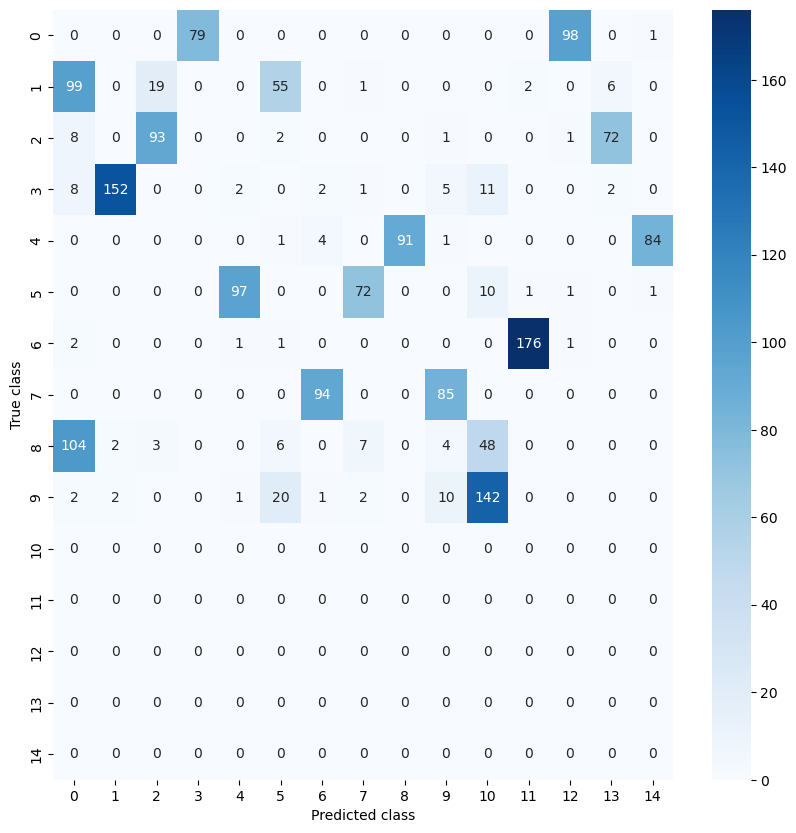

In [4]:
# predict the class labels for all samples
predictions = gmmUnsupervised.predict(X_pca)

# compute and plot the confusion matrix
cm = confusion_matrix(y, predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()


Now we use our supervised combined GMM to generate new data points. We observe that they resemble handwritten digits, but within each class, almost the exact same sample is generated each time we ask the GMM to produce a sample. This is the problem of memorization, as described in the report -- our supervised GMMs for each class have PDFs with extremely high variances and sharp peaks, and so repeatedly generate indistinguishable samples. 

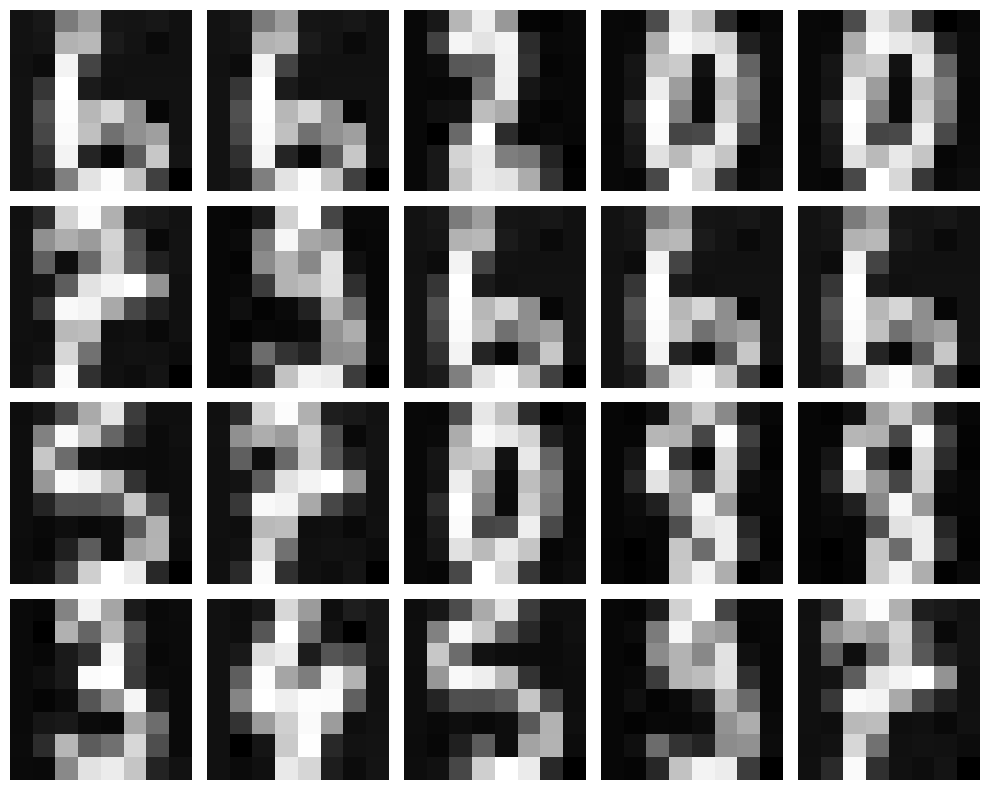

In [5]:
# initialize a figure for the plots
fig, axs = plt.subplots(4, 5, figsize=(10, 8))

# generate and plot 20 samples
for i in range(20):
    # choose a random GMM
    gmm = np.random.choice(gmms)
    
    # generate a sample from the GMM
    sample, _ = gmm.sample()
    
    # transform the sample back into the original space
    sample = pca.inverse_transform(sample)
    
    # reshape the sample into an 8x8 image
    image = sample.reshape(8, 8)
    
    # plot the image
    axs[i // 5, i % 5].imshow(image, cmap='gray')
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

Let's instead try generating 20 data points from our unsupervised model. This fixes the problem of memorization that we experienced in our supervised model, but not all of its generated samples are good enough to be suitable training data for a particular class. Still, the supervised model generated better samples, but was not able to vary them.

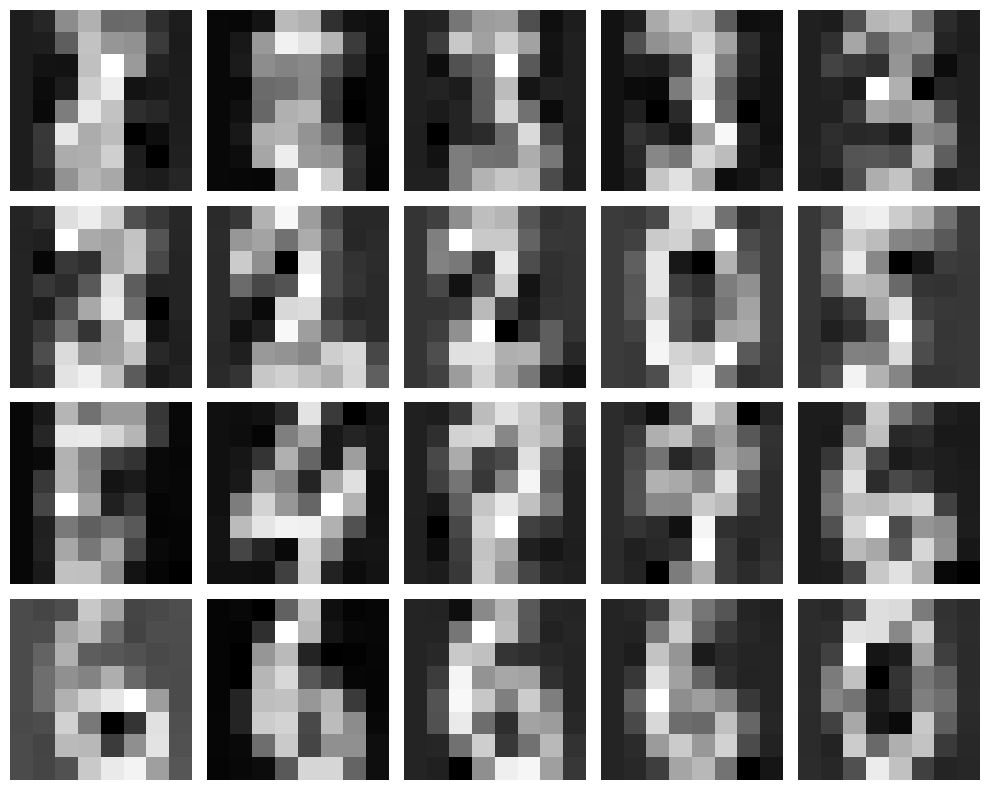

In [6]:
# generate 20 samples from the GMM
samples, _ = gmmUnsupervised.sample(20)

# transform the samples back to the original space
samples = pca.inverse_transform(samples)

# reshape the samples to 8x8 images
samples = samples.reshape(-1, 8, 8)

# plot the samples in 4 rows of 5
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Finally, we compare the success of our model to other classification methods, namely that of a gradient boosted tree classification and random forest classification on the same PCA-compressed MNIST data, by plotting confusion matrices for both methods.

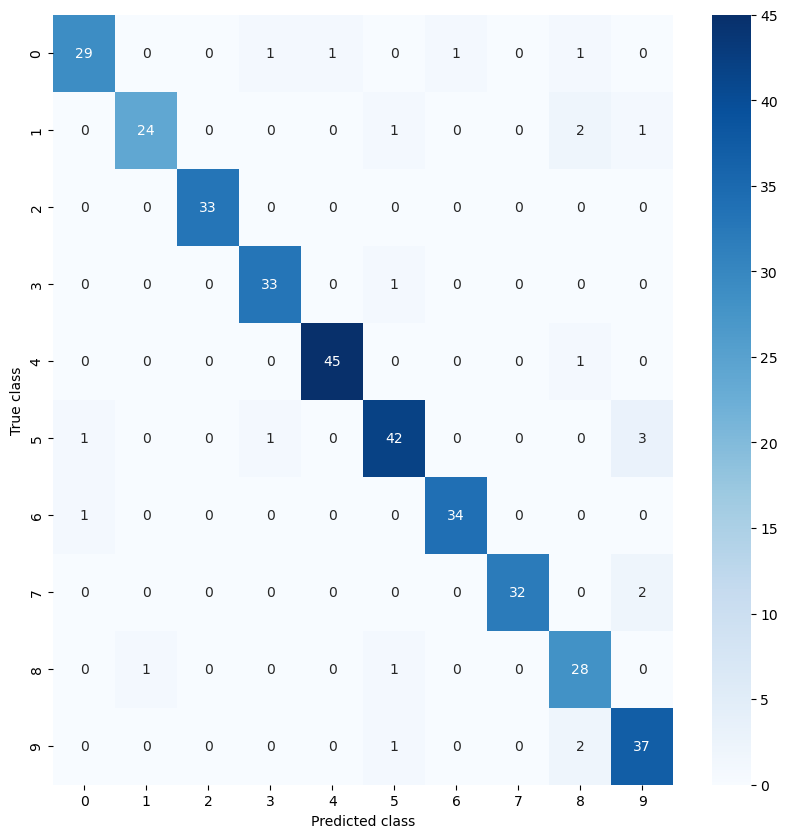

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# train a gradient boosted tree classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# predict the labels for the test set
y_pred_gb = gb.predict(X_test)

# compute the confusion matrix for the Gradient Boosting Classifier
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10, 10))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

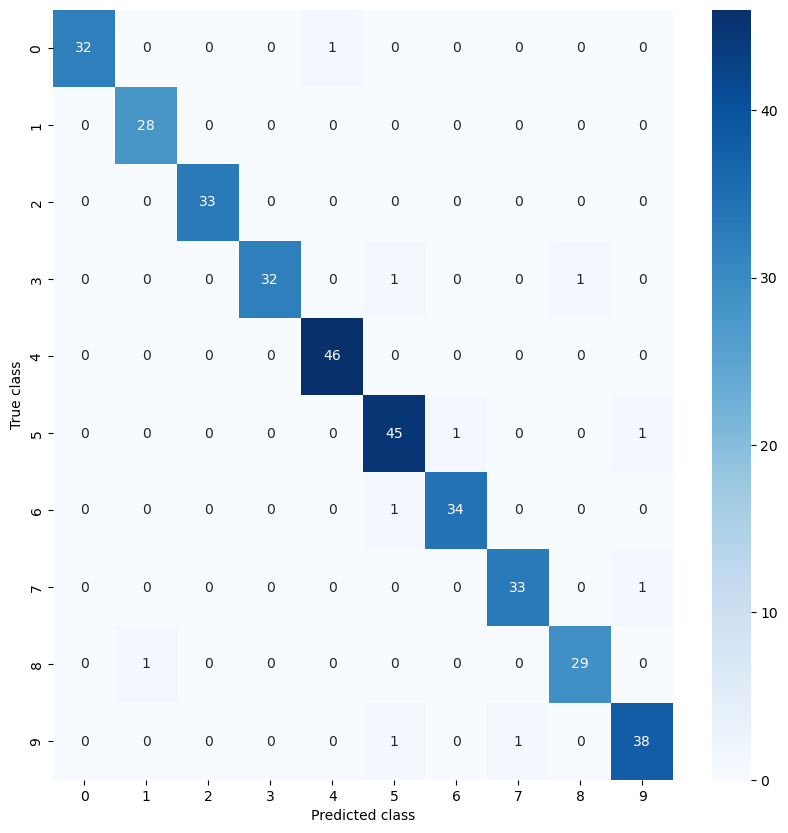

In [8]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model
clf.fit(X_train, y_train)

# make predictions on the test set
y_pred = clf.predict(X_test)

# compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()